In [231]:
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

#pd.set_option("display.max_rows", 5)

trainpath = 'train.csv'
testpath = 'test.csv'

trainframe = pd.read_csv(trainpath)
testframe = pd.read_csv(testpath)



In [232]:
trainy = trainframe.Survived
trainframe.dropna(axis = 'rows', subset = ['Survived'], inplace = True)
trainframe = trainframe.drop('Survived', axis = 1)


print(trainframe.columns)
print(trainframe.head())
print('\n\n')

trainframe['Child'] = trainframe.Age.map(lambda b: True if b <12 else False)
trainframe['Teen'] = trainframe.Age.map(lambda b: True if b >12 and b <18 else False)
testframe['Child'] = testframe.Age.map(lambda b: True if b < 12 else False)
testframe['Teen'] = testframe.Age.map(lambda b: True if b >12 and b < 18 else False)

print(trainframe[trainframe.Age <18].Age)
print('\n\n')
print(trainframe[trainframe.Age<18].Child)
print('\n\n')
print(trainframe[trainframe.Age<18].Teen)

print(trainframe.columns)



Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
   PassengerId  Pclass                                               Name  \
0            1       3                            Braund, Mr. Owen Harris   
1            2       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2            3       3                             Heikkinen, Miss. Laina   
3            4       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4            5       3                           Allen, Mr. William Henry   

      Sex   Age  SibSp  Parch            Ticket     Fare Cabin Embarked  
0    male  22.0      1      0         A/5 21171   7.2500   NaN        S  
1  female  38.0      1      0          PC 17599  71.2833   C85        C  
2  female  26.0      0      0  STON/O2. 3101282   7.9250   NaN        S  
3  female  35.0      1      0            113803  53.1000  C123        S  
4    male  35.0      0    

In [233]:
trainframe['LastName'] = trainframe.Name.map(lambda b: b.split(',', 1)[0])
testframe['LastName'] = testframe.Name.map(lambda b: b.split(',', 1)[0])

trainframe['Title'] = trainframe.Name.map(lambda b: b.split('.', 1)[0].split(' ')[-1])
testframe['Title'] = testframe.Name.map(lambda b: b.split('.', 1)[0].split(' ')[-1])

def titles(title):
    if title in ['Major', 'Col', 'Capt']:
        return 'Military'
    if title in ['Rev', 'Jonkheer', 'Countess', 'Don']:
        return 'HighClass'
    if title in ['Mlle', 'Ms', 'Dona', 'Lady']:
        return 'Miss'
    if title in ['Mme']:
        return 'Mrs'
    if title in ['Master', 'Sir']:
        return 'Mr'
    else: 
        return title
    
trainframe['Title'] = trainframe.Title.map(lambda b: titles(b))
testframe['Title'] = testframe.Title.map(lambda b: titles(b))

trainframe = trainframe.drop(['Name'], axis =1)
testframe = testframe.drop(['Name'], axis =1)

print(trainframe.LastName)


0       Braund
1      Cumings
        ...   
889       Behr
890     Dooley
Name: LastName, Length: 891, dtype: object


In [234]:

costnamedict = {}
costnamedicttest = {}

LastNames = trainframe.groupby('LastName').size().sort_values(ascending = False)

print(LastNames)
print(trainframe.at[3, 'LastName'])

for i in range(len(trainframe.index)):
    if trainframe.at[i, 'LastName'] in costnamedict:
        costnamedict[trainframe.at[i, 'LastName']] += trainframe.at[i, 'Fare']
    else:
        costnamedict[trainframe.at[i, 'LastName']] = trainframe.at[i, 'Fare']

for i in range(len(testframe.index)):
    if testframe.at[i, 'LastName'] in costnamedicttest:
        costnamedicttest[testframe.at[i, 'LastName']] += testframe.at[i, 'Fare']
    else:
        costnamedicttest[testframe.at[i, 'LastName']] = testframe.at[i, 'Fare']
#print(costnamedict)
trainframe['TotalCost'] =trainframe.LastName.map(lambda p: round(costnamedict[p], 2))
testframe['TotalCost'] = testframe.LastName.map(lambda p: round(costnamedicttest[p], 2))

print(trainframe.TotalCost)
print(trainframe.Title)

LastName
Andersson    9
Sage         7
            ..
Moutal       1
Abbing       1
Length: 667, dtype: int64
Futrelle
0      14.30
1      71.28
       ...  
889    30.00
890     7.75
Name: TotalCost, Length: 891, dtype: float64
0       Mr
1      Mrs
      ... 
889     Mr
890     Mr
Name: Title, Length: 891, dtype: object


In [235]:

trainframe['Cabin'] = trainframe['Cabin'].replace('Unknown', np.nan)
testframe['Cabin'] = testframe['Cabin'].replace('Unknown', np.nan)

def cabins(x):
    if x in [np.nan]:
        return x
    else:
        return str(x)[:1]
    

trainframe['Deck'] = trainframe['Cabin'].map(lambda x:cabins(x))
testframe['Deck'] = trainframe['Cabin'].map(lambda x: cabins(x))

trainframe = trainframe.drop('Cabin', axis =1)
testframe = testframe.drop('Cabin', axis = 1)


In [236]:

trainframe['FamilySize']=trainframe['SibSp']+trainframe['Parch']
trainframe['ClassDAge'] = trainframe['Pclass']/trainframe['Age']
trainframe['FarePerPerson'] = trainframe['TotalCost']/(trainframe['FamilySize'] + 1)

testframe['FamilySize']=testframe['SibSp']+testframe['Parch']
testframe['ClassDAge'] = testframe['Pclass']/testframe['Age']
testframe['FarePerPerson'] = testframe['TotalCost']/(testframe['FamilySize'] + 1)



In [237]:

print(trainframe.columns)
print(testframe.columns) 

total_cols = []
for i in trainframe.columns:
    if (trainframe[i].nunique() <10 and trainframe[i].dtype == 'object') or trainframe[i].dtype in ['int64', 'float64', 'bool']:
        total_cols.append(i)
print(total_cols)

trainframe = trainframe[total_cols]
testframe = testframe[total_cols]

columns_with_empty = []
for i in trainframe.columns:
    if trainframe[i].isnull().any():
        columns_with_empty.append(i)
        
for i in columns_with_empty:
    trainframe[i + '_was_empty'] = trainframe[i].isnull()
    testframe[i + 'was_empty'] = testframe[i].isnull()

trainframe = pd.get_dummies(trainframe)
testframe = pd.get_dummies(testframe)

print(trainframe.columns)
print(testframe.columns)

my_imputer = Imputer()
trainframeImputed = my_imputer.fit_transform(trainframe)
testframeImputed = my_imputer.fit_transform(testframe)

trainframe = pd.DataFrame(trainframeImputed, index = trainframe.index, columns = trainframe.columns)
testframe = pd.DataFrame(testframeImputed, index = testframe.index, columns = testframe.columns)
    
trainframe, testframe = trainframe.align(testframe, join = 'inner', axis = 'columns')




Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Embarked', 'Child', 'Teen', 'LastName', 'Title', 'TotalCost',
       'Deck', 'FamilySize', 'ClassDAge', 'FarePerPerson'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Embarked', 'Child', 'Teen', 'LastName', 'Title', 'TotalCost',
       'Deck', 'FamilySize', 'ClassDAge', 'FarePerPerson'],
      dtype='object')
['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Child', 'Teen', 'Title', 'TotalCost', 'Deck', 'FamilySize', 'ClassDAge', 'FarePerPerson']
Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Child',
       'Teen', 'TotalCost', 'FamilySize', 'ClassDAge', 'FarePerPerson',
       'Age_was_empty', 'Embarked_was_empty', 'Deck_was_empty',
       'ClassDAge_was_empty', 'Sex_female', 'Sex_male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Title_Dr', 'Title_HighClass',
       'Title_Mil

In [238]:
# train_x, tval_x, train_y, tval_y = train_test_split(trainframe, trainy, test_size = 0.2)

# minNum = 9999999999999
# numVal = 0

# for i in range(50, 15000, 50):
#     mymodel = XGBClassifier().set_params(learning_rate = 0.01, n_estimators = i, n_jobs =-1)
#     mymodel.fit(train_x, train_y)
#     predictions = mymodel.predict(tval_x)
#     mae = mean_absolute_error(tval_y, predictions)
#     print('At %s n_estimators, the MAE was %2f'%(i, mae))
#     if mae < minNum:
#         minNum = mae
#         numVal = i
# print('The best MAE was %2f at %s n_estimators'%(minNum, numVal))

import matplotlib.pylab as plt
import xgboost as xgb
%matplotlib inline
from matplotlib.pylab import rcParams
from sklearn import metrics
rcParams['figure.figsize'] = 12, 4

temp = trainframe
temp['Survived'] = trainy
train = temp
target = 'Survived'
IDcol = 'PassengerId'


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1000, 'n_jobs': 1, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': True, 'subsample': 0.8}
[0]	train-auc:0.885889+0.00759726	test-auc:0.838169+0.0274959
[1]	train-auc:0.899766+0.00183391	test-auc:0.850186+0.0215044
[2]	train-auc:0.906307+0.00732708	test-auc:0.861029+0.0209079
[3]	train-auc:0.911666+0.00758161	test-auc:0.860264+0.0181926
[4]	train-auc:0.914856+0.00654906	test-auc:0.861513+0.0224406
[5]	train-auc:0.917942+0.00780537	test-auc:0.863323+0.0248426
[6]	train-auc:0.921086+0.00851161	test-auc:0.868723+0.0191045
[7]	train-auc:0.921919+0.00913622	test-auc:0.867436+0.018652
[8]	train-auc:0.923918+0.00717926	test-auc:0.868335+0.0237577
[9]	train-auc:0.925138+0.00658165	test-a

[125]	train-auc:0.992081+0.000957382	test-auc:0.870829+0.0252055
[126]	train-auc:0.992218+0.000901796	test-auc:0.871118+0.0256445
[127]	train-auc:0.9924+0.000951709	test-auc:0.871085+0.0254431
[128]	train-auc:0.992565+0.000958468	test-auc:0.87104+0.024942
[129]	train-auc:0.992707+0.000904426	test-auc:0.870945+0.0253802
[130]	train-auc:0.992847+0.000863156	test-auc:0.870599+0.0256027
[131]	train-auc:0.992976+0.000873798	test-auc:0.870614+0.0253368
[132]	train-auc:0.992972+0.00087965	test-auc:0.871261+0.025854
[133]	train-auc:0.993048+0.000971326	test-auc:0.871474+0.0259142
[134]	train-auc:0.993139+0.000946896	test-auc:0.871743+0.0252265
[135]	train-auc:0.993332+0.00081223	test-auc:0.871514+0.0256662
[136]	train-auc:0.993398+0.000815231	test-auc:0.871269+0.0255941
[137]	train-auc:0.993404+0.000854499	test-auc:0.871336+0.0258782
[138]	train-auc:0.993482+0.000832117	test-auc:0.87116+0.0256437
[139]	train-auc:0.993574+0.00088948	test-auc:0.871878+0.0255397
[140]	train-auc:0.993623+0.0010104

[253]	train-auc:0.998256+0.00031985	test-auc:0.869918+0.0245304
[254]	train-auc:0.998291+0.000331705	test-auc:0.869865+0.0242391
[255]	train-auc:0.998291+0.000346971	test-auc:0.870424+0.0245014
[256]	train-auc:0.998308+0.000344151	test-auc:0.870281+0.0248015
[257]	train-auc:0.998328+0.000354321	test-auc:0.869856+0.025088
[258]	train-auc:0.998302+0.000370564	test-auc:0.8699+0.025222
[259]	train-auc:0.998295+0.000376767	test-auc:0.870199+0.0249178
[260]	train-auc:0.998328+0.000357299	test-auc:0.870046+0.0248955
[261]	train-auc:0.998333+0.000358871	test-auc:0.869877+0.024997
[262]	train-auc:0.998361+0.000350996	test-auc:0.869867+0.0251895
[263]	train-auc:0.998358+0.000368655	test-auc:0.870002+0.0248969
[264]	train-auc:0.998361+0.000351894	test-auc:0.869523+0.0251113
[265]	train-auc:0.998358+0.000356854	test-auc:0.869495+0.0249098
[266]	train-auc:0.998375+0.000363834	test-auc:0.869209+0.0253225
[267]	train-auc:0.998385+0.000343618	test-auc:0.869342+0.0253638
[268]	train-auc:0.9984+0.000347

[380]	train-auc:0.99918+0.0002693	test-auc:0.867005+0.0269298
[381]	train-auc:0.99917+0.00028327	test-auc:0.867194+0.0267039
[382]	train-auc:0.999198+0.000269048	test-auc:0.867301+0.0267806
[383]	train-auc:0.999195+0.000263337	test-auc:0.86767+0.0272232
[384]	train-auc:0.999201+0.000262326	test-auc:0.867843+0.0271289
[385]	train-auc:0.999216+0.000264343	test-auc:0.86748+0.027407
[386]	train-auc:0.9992+0.000260193	test-auc:0.867521+0.0273941
[387]	train-auc:0.999195+0.00026359	test-auc:0.867865+0.0274376
[388]	train-auc:0.999206+0.000259663	test-auc:0.867823+0.0274834
[389]	train-auc:0.999198+0.00026302	test-auc:0.867604+0.0271088
[390]	train-auc:0.99919+0.000268261	test-auc:0.867574+0.0272583
[391]	train-auc:0.999193+0.000268551	test-auc:0.867814+0.0273645
[392]	train-auc:0.999186+0.000255325	test-auc:0.868052+0.0271101
[393]	train-auc:0.999188+0.000284252	test-auc:0.867881+0.0268151
[394]	train-auc:0.999173+0.000276573	test-auc:0.867797+0.0269987
[395]	train-auc:0.999188+0.000266719	t

[507]	train-auc:0.999416+0.000199733	test-auc:0.865698+0.0281076
[508]	train-auc:0.999427+0.00018769	test-auc:0.86595+0.0281338
[509]	train-auc:0.999432+0.000186611	test-auc:0.866133+0.0281388
[510]	train-auc:0.999434+0.000183855	test-auc:0.865904+0.0282553
[511]	train-auc:0.999432+0.00017516	test-auc:0.86582+0.028193
[512]	train-auc:0.999434+0.000180675	test-auc:0.865963+0.0286621
[513]	train-auc:0.999435+0.000186629	test-auc:0.866312+0.028527
[514]	train-auc:0.999444+0.00019274	test-auc:0.866142+0.0283838
[515]	train-auc:0.999443+0.000199546	test-auc:0.866224+0.0282287
[516]	train-auc:0.999444+0.00019808	test-auc:0.866186+0.0282184
[517]	train-auc:0.99945+0.000196595	test-auc:0.86593+0.0283023
[518]	train-auc:0.999445+0.000192977	test-auc:0.865608+0.0280441
[519]	train-auc:0.999432+0.00019698	test-auc:0.866057+0.0280115
[520]	train-auc:0.999437+0.000199974	test-auc:0.866294+0.0279247
[521]	train-auc:0.99944+0.000200147	test-auc:0.865955+0.0279789
[522]	train-auc:0.999437+0.000198522	

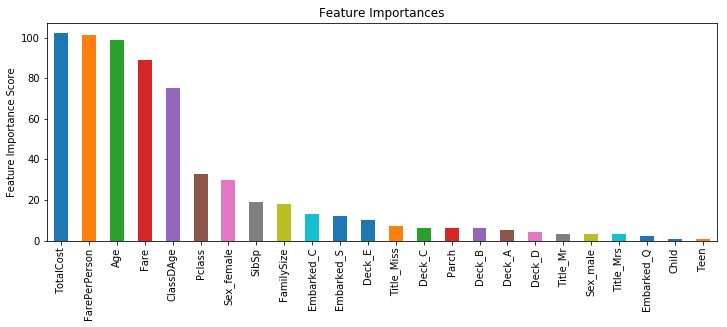

In [239]:

# if useTrainCV:
#         xgbParams = alg.get_xgb_params()
#         xgTrain = xgb.DMatrix(X, label=y)
#         cvresult = xgb.cv(xgbParams,
#                       xgTrain,
#                       num_boost_round=alg.get_params()['n_estimators'],
#                       nfold=cvFolds,
#                       stratified=True,
#                       metrics={'mlogloss'},
#                       early_stopping_rounds=early_stopping_rounds,
#                       seed=0,
#                       callbacks=[xgb.callback.print_evaluation(show_stdv=False),                                                               xgb.callback.early_stop(3)])

#         print cvresult
#         alg.set_params(n_estimators=cvresult.shape[0])


def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=500):
    
    #if useTrainCV:
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
    cvresult = xgb.cv(xgb_param, 
                        xgtrain, 
                        num_boost_round=alg.get_params()['n_estimators'], 
                        nfold=cv_folds,
                        metrics='auc', 
                        early_stopping_rounds=early_stopping_rounds, 
                        verbose_eval=False,
                        callbacks=[xgb.callback.print_evaluation(show_stdv=True)])

        
    alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Survived'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Survived'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Survived'], dtrain_predprob))    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    print(alg.get_params)
    print(cvresult.iloc[len(cvresult)-1])

    
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
print(xgb1.get_params())
modelfit(xgb1, train, predictors)


In [240]:

param_test1 = {
 'max_depth':range(3,15,1),
 'min_child_weight':range(1,10,1)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=37, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_


C:\Users\ronan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\ronan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\ronan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\ronan\Anaconda3\lib\site-packages\sklearn\util

({'mean_fit_time': array([ 0.0209332 ,  0.03370881,  0.03530359,  0.02852192,  0.0285223 ,
          0.02812428,  0.02991924,  0.03051782,  0.02912149,  0.03809762,
          0.0361032 ,  0.03630257,  0.03630261,  0.03530517,  0.04208732,
          0.03909516,  0.0406908 ,  0.04128904,  0.067419  ,  0.0508266 ,
          0.05452518,  0.05351238,  0.04972873,  0.05047216,  0.04527879,
          0.04368243,  0.03989286,  0.05884209,  0.0527596 ,  0.05126529,
          0.04917221,  0.04807439,  0.04777613,  0.04926782,  0.04727297,
          0.04348335,  0.06921468,  0.0622334 ,  0.05844359,  0.05525203,
          0.05066442,  0.05046492,  0.04966707,  0.04707384,  0.04507933,
          0.07300444,  0.06642175,  0.06482663,  0.06861601,  0.06023841,
          0.06612291,  0.06054153,  0.05476346,  0.04928002,  0.08589048,
          0.07490048,  0.06472778,  0.06173544,  0.05445399,  0.05265875,
          0.04946752,  0.04707379,  0.0464756 ,  0.08726764,  0.07551613,
          0.06719747,

In [241]:

param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=37, max_depth=9,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_


C:\Users\ronan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\ronan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\ronan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\ronan\Anaconda3\lib\site-packages\sklearn\util

({'mean_fit_time': array([ 0.03648038,  0.053655  ,  0.05565438,  0.05525117,  0.0474719 ]),
  'std_fit_time': array([ 0.01501128,  0.00146622,  0.00270716,  0.00135372,  0.00823874]),
  'mean_score_time': array([ 0.00139632,  0.00179558,  0.00179543,  0.00139623,  0.00099721]),
  'std_score_time': array([  4.88402554e-04,   3.99017476e-04,   3.99065089e-04,
           4.88383205e-04,   2.43140197e-07]),
  'param_gamma': masked_array(data = [0.0 0.1 0.2 0.3 0.4],
               mask = [False False False False False],
         fill_value = ?),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([ 0.84815547,  0.84881423,  0.84657444,  0.84591568,  0.84802372]),
  'split1_test_score': array([ 0.83932806,  0.83722003,  0.83774704,  0.83715415,  0.83893281]),
  'split2_test_score': array([ 0.90073529,  0.89792781,  0.90086898,  0.89639037,  0.89699198]),
  'split3_test_score': array([ 0.89532086,  0.88783422

[0]	train-auc:0.870742+0.00730907	test-auc:0.844239+0.0201204
[1]	train-auc:0.87639+0.00783559	test-auc:0.85063+0.0183823
[2]	train-auc:0.884129+0.0105724	test-auc:0.855026+0.0236834
[3]	train-auc:0.889604+0.00918115	test-auc:0.860643+0.0283891
[4]	train-auc:0.894508+0.00526094	test-auc:0.863374+0.0316524
[5]	train-auc:0.897328+0.00424255	test-auc:0.863739+0.029099
[6]	train-auc:0.901008+0.00422935	test-auc:0.866736+0.0238154
[7]	train-auc:0.902588+0.00435087	test-auc:0.865914+0.0231571
[8]	train-auc:0.904764+0.00363483	test-auc:0.862067+0.0235782
[9]	train-auc:0.906897+0.00430217	test-auc:0.862492+0.0253968
[10]	train-auc:0.909275+0.00452225	test-auc:0.864502+0.0252671
[11]	train-auc:0.910659+0.00351859	test-auc:0.865151+0.0228162
[12]	train-auc:0.912376+0.00359277	test-auc:0.866379+0.0228763
[13]	train-auc:0.913688+0.00354335	test-auc:0.867639+0.0243671
[14]	train-auc:0.915445+0.00361412	test-auc:0.8691+0.025341
[15]	train-auc:0.916657+0.0040072	test-auc:0.869643+0.0249954
[16]	train

[131]	train-auc:0.972297+0.00156874	test-auc:0.876163+0.0259446
[132]	train-auc:0.972464+0.00163274	test-auc:0.876297+0.0263075
[133]	train-auc:0.972656+0.00166298	test-auc:0.876476+0.0264671
[134]	train-auc:0.97284+0.00172046	test-auc:0.876045+0.0265759
[135]	train-auc:0.973078+0.00164178	test-auc:0.875946+0.0268003
[136]	train-auc:0.973274+0.00170976	test-auc:0.875823+0.0260481
[137]	train-auc:0.973248+0.00181729	test-auc:0.87649+0.0264919
[138]	train-auc:0.973395+0.0019055	test-auc:0.876602+0.02669
[139]	train-auc:0.973572+0.00207855	test-auc:0.876367+0.0275771
[140]	train-auc:0.973677+0.00200299	test-auc:0.876321+0.0273092
[141]	train-auc:0.973952+0.00206744	test-auc:0.876185+0.0273133
[142]	train-auc:0.974078+0.00207297	test-auc:0.876208+0.027255
[143]	train-auc:0.974246+0.00202496	test-auc:0.875749+0.0272167
[144]	train-auc:0.974471+0.00208718	test-auc:0.875552+0.026662
[145]	train-auc:0.974594+0.00207717	test-auc:0.875259+0.027109
[146]	train-auc:0.974847+0.00198146	test-auc:0.8

[260]	train-auc:0.985574+0.00107658	test-auc:0.872873+0.0264576
[261]	train-auc:0.985554+0.00117321	test-auc:0.872849+0.027039
[262]	train-auc:0.985601+0.00110439	test-auc:0.873198+0.0268379
[263]	train-auc:0.985619+0.00109763	test-auc:0.872543+0.0266638
[264]	train-auc:0.985672+0.00113852	test-auc:0.872755+0.0263617
[265]	train-auc:0.985752+0.00115564	test-auc:0.872827+0.0260259
[266]	train-auc:0.985791+0.00120978	test-auc:0.872796+0.0267327
[267]	train-auc:0.985852+0.00124555	test-auc:0.87298+0.026294
[268]	train-auc:0.985909+0.00122232	test-auc:0.872791+0.0263676
[269]	train-auc:0.985958+0.00118359	test-auc:0.872766+0.0264941
[270]	train-auc:0.986087+0.00110649	test-auc:0.872469+0.0261248
[271]	train-auc:0.986169+0.00113413	test-auc:0.872039+0.0260342
[272]	train-auc:0.986142+0.00112327	test-auc:0.872714+0.0258877
[273]	train-auc:0.986188+0.00104649	test-auc:0.873088+0.0257133
[274]	train-auc:0.986257+0.0010584	test-auc:0.873035+0.0256832
[275]	train-auc:0.986347+0.00108497	test-auc

[388]	train-auc:0.990647+0.000730924	test-auc:0.872008+0.0279403
[389]	train-auc:0.990648+0.000731276	test-auc:0.872379+0.0278262
[390]	train-auc:0.990721+0.000703756	test-auc:0.872298+0.0276377
[391]	train-auc:0.990696+0.00067209	test-auc:0.872236+0.0279287
[392]	train-auc:0.990721+0.000706994	test-auc:0.87245+0.0278893
[393]	train-auc:0.990744+0.000682081	test-auc:0.872482+0.0278066
[394]	train-auc:0.990729+0.000716918	test-auc:0.872485+0.0277233
[395]	train-auc:0.990832+0.000766887	test-auc:0.872683+0.0276018
[396]	train-auc:0.990846+0.000751663	test-auc:0.872794+0.027698
[397]	train-auc:0.990874+0.000761463	test-auc:0.872272+0.0278215
[398]	train-auc:0.990909+0.000754954	test-auc:0.872486+0.0279589
[399]	train-auc:0.990929+0.000795843	test-auc:0.872213+0.0277667
[400]	train-auc:0.990956+0.0008002	test-auc:0.871746+0.0276401
[401]	train-auc:0.990908+0.000849202	test-auc:0.872212+0.0273611
[402]	train-auc:0.990929+0.000840902	test-auc:0.87218+0.0270795
[403]	train-auc:0.990946+0.0007

[515]	train-auc:0.993198+0.000610685	test-auc:0.87043+0.0294394
[516]	train-auc:0.993193+0.000593877	test-auc:0.870463+0.0295491
[517]	train-auc:0.993196+0.00060769	test-auc:0.870614+0.0294346
[518]	train-auc:0.993273+0.000600698	test-auc:0.870716+0.0292642
[519]	train-auc:0.993285+0.000552061	test-auc:0.871231+0.0290687
[520]	train-auc:0.993275+0.000602831	test-auc:0.871287+0.0287836
[521]	train-auc:0.993245+0.000587413	test-auc:0.87107+0.028882
[522]	train-auc:0.993312+0.000569261	test-auc:0.870767+0.028861
[523]	train-auc:0.993332+0.000584023	test-auc:0.870841+0.028644
[524]	train-auc:0.99334+0.000562243	test-auc:0.870809+0.0288447
[525]	train-auc:0.993336+0.000594826	test-auc:0.870914+0.0285927
[526]	train-auc:0.993355+0.000586463	test-auc:0.870704+0.0290084
[527]	train-auc:0.993394+0.000613949	test-auc:0.870678+0.0288548
[528]	train-auc:0.993435+0.000603581	test-auc:0.870978+0.0289492
[529]	train-auc:0.993407+0.000575963	test-auc:0.870725+0.0288949
[530]	train-auc:0.993446+0.00057

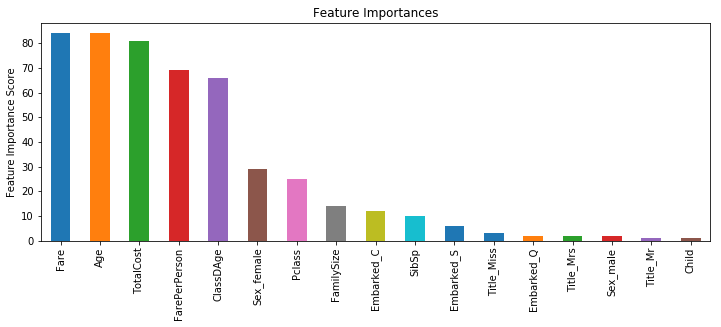

In [242]:

xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=5,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train, predictors)


In [243]:
param_test4 = {
 'subsample':[i/100.0 for i in range(60,100)],
 'colsample_bytree':[i/100.0 for i in range(60,100)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=33, max_depth=9,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

C:\Users\ronan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.86817, std: 0.02452, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.87257, std: 0.02411, params: {'colsample_bytree': 0.6, 'subsample': 0.61},
  mean: 0.87211, std: 0.02560, params: {'colsample_bytree': 0.6, 'subsample': 0.62},
  mean: 0.87147, std: 0.02511, params: {'colsample_bytree': 0.6, 'subsample': 0.63},
  mean: 0.87267, std: 0.02413, params: {'colsample_bytree': 0.6, 'subsample': 0.64},
  mean: 0.87275, std: 0.02607, params: {'colsample_bytree': 0.6, 'subsample': 0.65},
  mean: 0.87013, std: 0.02532, params: {'colsample_bytree': 0.6, 'subsample': 0.66},
  mean: 0.87407, std: 0.02461, params: {'colsample_bytree': 0.6, 'subsample': 0.67},
  mean: 0.87504, std: 0.02532, params: {'colsample_bytree': 0.6, 'subsample': 0.68},
  mean: 0.87659, std: 0.02660, params: {'colsample_bytree': 0.6, 'subsample': 0.69},
  mean: 0.87541, std: 0.02617, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.87531, std: 0.02719, params: {'colsample_bytree': 0.6, 's

In [244]:
param_test7 = {
 'reg_alpha':[i/100 for i in range(0, 100)]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=33, max_depth=9,
 min_child_weight=5, gamma=0, subsample=0.98, colsample_bytree=0.94,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

C:\Users\ronan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.88007, std: 0.02704, params: {'reg_alpha': 0.0},
  mean: 0.87917, std: 0.02618, params: {'reg_alpha': 0.01},
  mean: 0.87919, std: 0.02520, params: {'reg_alpha': 0.02},
  mean: 0.88056, std: 0.02660, params: {'reg_alpha': 0.03},
  mean: 0.88027, std: 0.02660, params: {'reg_alpha': 0.04},
  mean: 0.88019, std: 0.02624, params: {'reg_alpha': 0.05},
  mean: 0.87796, std: 0.02664, params: {'reg_alpha': 0.06},
  mean: 0.87935, std: 0.02732, params: {'reg_alpha': 0.07},
  mean: 0.87822, std: 0.02712, params: {'reg_alpha': 0.08},
  mean: 0.87902, std: 0.02770, params: {'reg_alpha': 0.09},
  mean: 0.88021, std: 0.02435, params: {'reg_alpha': 0.1},
  mean: 0.87847, std: 0.02465, params: {'reg_alpha': 0.11},
  mean: 0.88009, std: 0.02614, params: {'reg_alpha': 0.12},
  mean: 0.87910, std: 0.02740, params: {'reg_alpha': 0.13},
  mean: 0.87929, std: 0.02478, params: {'reg_alpha': 0.14},
  mean: 0.87724, std: 0.02594, params: {'reg_alpha': 0.15},
  mean: 0.87754, std: 0.02676, params: {'r

[0]	train-auc:0.878253+0.00754787	test-auc:0.850205+0.0229421
[1]	train-auc:0.880013+0.00826514	test-auc:0.850759+0.0214388
[2]	train-auc:0.881537+0.00891628	test-auc:0.854304+0.0206504
[3]	train-auc:0.882091+0.00983028	test-auc:0.856413+0.0190113
[4]	train-auc:0.8829+0.00992399	test-auc:0.855155+0.0210887
[5]	train-auc:0.883591+0.0102748	test-auc:0.854897+0.0200299
[6]	train-auc:0.88397+0.0105577	test-auc:0.85508+0.0210194
[7]	train-auc:0.884015+0.00992552	test-auc:0.85636+0.0200592
[8]	train-auc:0.884328+0.0100207	test-auc:0.856001+0.0201891
[9]	train-auc:0.886337+0.00898073	test-auc:0.85658+0.0214332
[10]	train-auc:0.887878+0.00780406	test-auc:0.861964+0.0276134
[11]	train-auc:0.888302+0.00775454	test-auc:0.864042+0.0281162
[12]	train-auc:0.887688+0.00798795	test-auc:0.862684+0.027578
[13]	train-auc:0.887698+0.00802869	test-auc:0.862406+0.0278243
[14]	train-auc:0.887667+0.00835228	test-auc:0.862737+0.027431
[15]	train-auc:0.887835+0.00840145	test-auc:0.863457+0.0262766
[16]	train-au

[131]	train-auc:0.913493+0.00276301	test-auc:0.869958+0.024989
[132]	train-auc:0.913628+0.00274997	test-auc:0.870153+0.0250191
[133]	train-auc:0.913952+0.00268195	test-auc:0.869918+0.025946
[134]	train-auc:0.914015+0.00275609	test-auc:0.870047+0.0255622
[135]	train-auc:0.914344+0.0028585	test-auc:0.870711+0.0250612
[136]	train-auc:0.914707+0.00300917	test-auc:0.871075+0.0248227
[137]	train-auc:0.914801+0.0029639	test-auc:0.870794+0.0251568
[138]	train-auc:0.914941+0.00295498	test-auc:0.870924+0.0249828
[139]	train-auc:0.915099+0.00290322	test-auc:0.871097+0.0250545
[140]	train-auc:0.915181+0.00286737	test-auc:0.870757+0.0252734
[141]	train-auc:0.915308+0.00282063	test-auc:0.870899+0.0250907
[142]	train-auc:0.915332+0.00284574	test-auc:0.871201+0.0251708
[143]	train-auc:0.91557+0.00272964	test-auc:0.870794+0.0250999
[144]	train-auc:0.915645+0.00275807	test-auc:0.870719+0.0249615
[145]	train-auc:0.915757+0.00263809	test-auc:0.870879+0.0247954
[146]	train-auc:0.915809+0.0027007	test-auc:0

[260]	train-auc:0.930695+0.00224768	test-auc:0.875509+0.0232657
[261]	train-auc:0.930892+0.0022317	test-auc:0.875691+0.0232967
[262]	train-auc:0.931064+0.00222212	test-auc:0.875634+0.0233446
[263]	train-auc:0.931123+0.00220808	test-auc:0.875687+0.0237866
[264]	train-auc:0.931162+0.00223866	test-auc:0.875663+0.0237504
[265]	train-auc:0.93122+0.00228131	test-auc:0.875562+0.0237891
[266]	train-auc:0.931394+0.00224152	test-auc:0.875562+0.0234701
[267]	train-auc:0.931606+0.00225386	test-auc:0.875917+0.0232364
[268]	train-auc:0.931773+0.0022654	test-auc:0.875806+0.0233267
[269]	train-auc:0.931915+0.00230372	test-auc:0.876012+0.0234077
[270]	train-auc:0.931991+0.00226658	test-auc:0.876201+0.0235064
[271]	train-auc:0.93216+0.00225413	test-auc:0.876098+0.0238263
[272]	train-auc:0.93231+0.00228309	test-auc:0.876203+0.0236276
[273]	train-auc:0.932445+0.0022936	test-auc:0.876101+0.0237023
[274]	train-auc:0.932556+0.00229115	test-auc:0.876209+0.0237327
[275]	train-auc:0.932717+0.00236917	test-auc:0

[390]	train-auc:0.944092+0.00178955	test-auc:0.879245+0.0254624
[391]	train-auc:0.944172+0.00176893	test-auc:0.879276+0.0254804
[392]	train-auc:0.944305+0.00174759	test-auc:0.879383+0.0255982
[393]	train-auc:0.944391+0.00171503	test-auc:0.87956+0.0256898
[394]	train-auc:0.94446+0.00173158	test-auc:0.879587+0.0256602
[395]	train-auc:0.944546+0.00176768	test-auc:0.87938+0.0255128
[396]	train-auc:0.944632+0.00179531	test-auc:0.879511+0.0254798
[397]	train-auc:0.944722+0.00178048	test-auc:0.879536+0.0254822
[398]	train-auc:0.944804+0.00179925	test-auc:0.879458+0.0254872
[399]	train-auc:0.944879+0.00183319	test-auc:0.879355+0.0255057
[400]	train-auc:0.944946+0.00182188	test-auc:0.879223+0.0255557
[401]	train-auc:0.945036+0.0018816	test-auc:0.87917+0.0256496
[402]	train-auc:0.945069+0.00186383	test-auc:0.879281+0.0257299
[403]	train-auc:0.945191+0.00181055	test-auc:0.879521+0.0257601
[404]	train-auc:0.945273+0.00183307	test-auc:0.87955+0.0257115
[405]	train-auc:0.945323+0.0018489	test-auc:0.

[519]	train-auc:0.952208+0.00148382	test-auc:0.878365+0.0276604
[520]	train-auc:0.952278+0.00147743	test-auc:0.878148+0.0276577
[521]	train-auc:0.952337+0.00148193	test-auc:0.878317+0.0277154
[522]	train-auc:0.952392+0.00148888	test-auc:0.878315+0.0278825
[523]	train-auc:0.952447+0.00149422	test-auc:0.878263+0.0279916
[524]	train-auc:0.952499+0.00149365	test-auc:0.878182+0.0280834
[525]	train-auc:0.952586+0.0014774	test-auc:0.878259+0.0279761
[526]	train-auc:0.952651+0.00148898	test-auc:0.878209+0.0280468
[527]	train-auc:0.952691+0.00148453	test-auc:0.878263+0.0280705
[528]	train-auc:0.952733+0.00151185	test-auc:0.878344+0.0281355
[529]	train-auc:0.952803+0.00148407	test-auc:0.878237+0.0280433
[530]	train-auc:0.95286+0.00147681	test-auc:0.878258+0.0280102
[531]	train-auc:0.952888+0.00145753	test-auc:0.878187+0.0279328
[532]	train-auc:0.952929+0.00148205	test-auc:0.878238+0.0280402
[533]	train-auc:0.952962+0.00150477	test-auc:0.878159+0.0280101
[534]	train-auc:0.952993+0.00148808	test-a

[648]	train-auc:0.958155+0.00164983	test-auc:0.877533+0.0280831
[649]	train-auc:0.958203+0.0016586	test-auc:0.877506+0.0280255
[650]	train-auc:0.958249+0.00163918	test-auc:0.877401+0.0279805
[651]	train-auc:0.958309+0.0016465	test-auc:0.877425+0.0280055
[652]	train-auc:0.958368+0.00164856	test-auc:0.877399+0.0278177
[653]	train-auc:0.958414+0.00159333	test-auc:0.877397+0.0278977
[654]	train-auc:0.958464+0.00159321	test-auc:0.877455+0.0278236
[655]	train-auc:0.958476+0.00159913	test-auc:0.877455+0.0278528
[656]	train-auc:0.958502+0.00160192	test-auc:0.877482+0.0277442
[657]	train-auc:0.958529+0.00158634	test-auc:0.877484+0.0278019
[658]	train-auc:0.958567+0.00158928	test-auc:0.877451+0.0278745
[659]	train-auc:0.9586+0.00160306	test-auc:0.877372+0.0278652
[660]	train-auc:0.95865+0.00159565	test-auc:0.877477+0.027834
[661]	train-auc:0.958687+0.00160888	test-auc:0.877481+0.0277615
[662]	train-auc:0.958717+0.00161697	test-auc:0.877503+0.027736
[663]	train-auc:0.958742+0.00159944	test-auc:0.

[777]	train-auc:0.962648+0.00158603	test-auc:0.877482+0.0270917
[778]	train-auc:0.962692+0.00155797	test-auc:0.87743+0.0271268
[779]	train-auc:0.962732+0.00157689	test-auc:0.877381+0.027032
[780]	train-auc:0.962746+0.00156431	test-auc:0.877427+0.0269572
[781]	train-auc:0.962779+0.00159712	test-auc:0.877423+0.0269296
[782]	train-auc:0.96279+0.0015875	test-auc:0.877426+0.0268758
[783]	train-auc:0.962863+0.00158865	test-auc:0.877423+0.0268229
[784]	train-auc:0.962911+0.00156024	test-auc:0.877374+0.026886
[785]	train-auc:0.96294+0.00155372	test-auc:0.877298+0.0269225
[786]	train-auc:0.96298+0.00156939	test-auc:0.87743+0.0268434
[787]	train-auc:0.962997+0.00158499	test-auc:0.877405+0.0269446
[788]	train-auc:0.963036+0.00158212	test-auc:0.877329+0.026926
[789]	train-auc:0.963063+0.00160336	test-auc:0.877354+0.02695
[790]	train-auc:0.96311+0.00158641	test-auc:0.877461+0.0269664
[791]	train-auc:0.963166+0.00157851	test-auc:0.877509+0.0269334
[792]	train-auc:0.963173+0.00156658	test-auc:0.87740

[906]	train-auc:0.966699+0.00145684	test-auc:0.877281+0.0269186
[907]	train-auc:0.966742+0.00146669	test-auc:0.877254+0.0270202
[908]	train-auc:0.966752+0.00145617	test-auc:0.877307+0.0268477
[909]	train-auc:0.966789+0.00147106	test-auc:0.877312+0.0269364
[910]	train-auc:0.966822+0.00147947	test-auc:0.87739+0.0269067
[911]	train-auc:0.966876+0.00148953	test-auc:0.87734+0.0269261
[912]	train-auc:0.966902+0.00148514	test-auc:0.87747+0.0269204
[913]	train-auc:0.96691+0.0014743	test-auc:0.877473+0.0269576
[914]	train-auc:0.966943+0.00146132	test-auc:0.877418+0.0270673
[915]	train-auc:0.966955+0.00149717	test-auc:0.877526+0.0271161
[916]	train-auc:0.966985+0.00149273	test-auc:0.87747+0.0271
[917]	train-auc:0.96701+0.00146786	test-auc:0.877498+0.026991
[918]	train-auc:0.96704+0.0014553	test-auc:0.877448+0.0270184
[919]	train-auc:0.967064+0.00146903	test-auc:0.87745+0.0270864
[920]	train-auc:0.967111+0.00145562	test-auc:0.87745+0.0270782
[921]	train-auc:0.967128+0.00147167	test-auc:0.877475+0

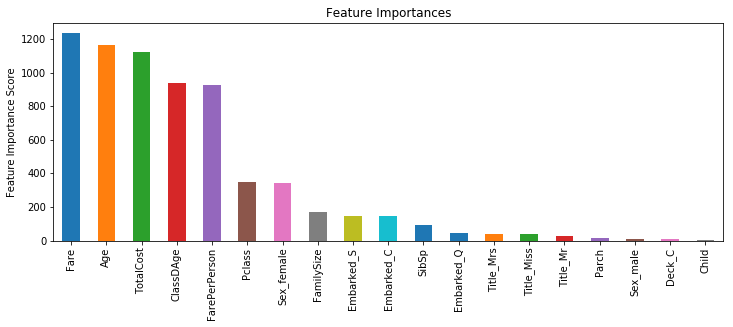

In [245]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=9,
 min_child_weight=5,
 gamma=0,
 subsample=0.98,
 colsample_bytree=0.94,
 reg_alpha=0.49,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, predictors)

In [256]:
print(trainframe.columns)
#trainframe = trainframe.drop('Survived', axis =1)
print(testframe.columns)
my_pipeline = make_pipeline(Imputer(), XGBClassifier().set_params(learning_rate =0.01,
 n_estimators=5000,
 max_depth=9,
 min_child_weight=5,
 gamma=0,
 subsample=0.98,
 colsample_bytree=0.94,
 reg_alpha=0.49,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,))

#xgbclassifier_learning_rate = 0.01, xgbregressor_n_estimators = 5050, xbgregressor_n_jobs = -1, xgbregressor_verbose = False

scores = cross_val_score(my_pipeline, trainframe, trainy, scoring='neg_mean_absolute_error', n_jobs = -1, cv = 3)
print(sum(scores)/-5)

my_pipeline.fit(trainframe, trainy)

predictions = my_pipeline.predict(testframe)
submission = pd.DataFrame({'PassengerId':testframe.PassengerId.astype('Int32'), 'Survived':predictions})
submission.to_csv('submission.csv', index = False)
print('done')

Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Child',
       'Teen', 'TotalCost', 'FamilySize', 'ClassDAge', 'FarePerPerson',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Title_Dr', 'Title_HighClass', 'Title_Military', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Child',
       'Teen', 'TotalCost', 'FamilySize', 'ClassDAge', 'FarePerPerson',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Title_Dr', 'Title_HighClass', 'Title_Military', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T'],
      dtype='object')
0.143434343434
done
